### Importing Libraries and Loading Data

In [27]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Load data
X_train = np.array(pd.read_csv('./train_data.csv', header=None))
X_test = np.array(pd.read_csv('./test_data.csv', header=None))
Y_train = np.array(pd.read_csv('./train_target.csv', header=None))

# Print shapes to verify data loading
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, Y_train shape: {Y_train.shape}")


X_train shape: (16175, 2304), X_test shape: (3965, 2304), Y_train shape: (16175, 1)


### Data Preprocessing

In [30]:
# Reshape and normalize the input data
X_train = X_train.reshape(-1, 48, 48).astype('float32') / 255
X_test = X_test.reshape(-1, 48, 48).astype('float32') / 255

# Expand dimensions to match the input shape requirement of the model
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# One-hot encode the labels
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
class_num = Y_train.shape[1]

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Print tensor shapes to verify
print(f"X_train tensor shape: {X_train.shape}, X_test tensor shape: {X_test.shape}, Y_train tensor shape: {Y_train.shape}")


X_train tensor shape: torch.Size([16175, 1, 48, 48]), X_test tensor shape: torch.Size([3965, 1, 48, 48]), Y_train tensor shape: torch.Size([16175, 3])


### Data Augmentation and Custom Dataset

In [33]:
# Define data augmentation transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),
])

# Custom dataset class to apply transformations
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        # Convert to PIL Image for transformations
        x = transforms.ToPILImage()(x)

        if self.transform:
            x = self.transform(x)

        # Convert back to tensor
        x = transforms.ToTensor()(x)
        return x, y

    def __len__(self):
        return len(self.tensors[0])


### Splitting Data and Creating Data Loaders

In [36]:
# Create dataset and apply data augmentation
dataset = CustomTensorDataset((X_train, Y_train), transform=transform)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=82, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=82, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")


Train dataset size: 14557, Validation dataset size: 1618


### Defining the CNN Model

In [53]:
# Define the CNN model with Batch Normalization and Dropout
class FacialExpressionRecognitionCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(FacialExpressionRecognitionCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding='same')
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding='same')
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, padding='same')
        
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(512 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.batchnorm1(self.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(self.relu(self.conv2(x))))
        x = self.pool(self.batchnorm3(self.relu(self.conv3(x))))
        x = self.pool(self.batchnorm4(self.relu(self.conv4(x))))
        x = self.pool(self.batchnorm5(self.relu(self.conv5(x))))
        
        x = x.view(-1, 512 * 1 * 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = FacialExpressionRecognitionCNNModel(num_classes=class_num)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


### Training the Model

In [56]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_accuracy = 0
best_model_path = 'bestModel.pth'

# training the model with epochs set to 300
for epoch in range(300):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_accuracy = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == torch.max(labels, 1)[1])

    val_accuracy = val_accuracy.double() / len(val_dataset)
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved at epoch {epoch + 1} with validation accuracy: {val_accuracy:.4f}")



Epoch 1, Train Loss: 1.0723, Val Loss: 1.0689, Val Accuracy: 0.4512
Model saved at epoch 1 with validation accuracy: 0.4512
Epoch 2, Train Loss: 1.0594, Val Loss: 1.0714, Val Accuracy: 0.4506
Epoch 3, Train Loss: 1.0186, Val Loss: 0.9798, Val Accuracy: 0.5482
Model saved at epoch 3 with validation accuracy: 0.5482
Epoch 4, Train Loss: 0.9537, Val Loss: 0.8879, Val Accuracy: 0.5822
Model saved at epoch 4 with validation accuracy: 0.5822
Epoch 5, Train Loss: 0.8967, Val Loss: 0.9121, Val Accuracy: 0.5878
Model saved at epoch 5 with validation accuracy: 0.5878
Epoch 6, Train Loss: 0.8610, Val Loss: 0.8797, Val Accuracy: 0.5939
Model saved at epoch 6 with validation accuracy: 0.5939
Epoch 7, Train Loss: 0.8287, Val Loss: 0.8343, Val Accuracy: 0.6112
Model saved at epoch 7 with validation accuracy: 0.6112
Epoch 8, Train Loss: 0.7992, Val Loss: 0.7831, Val Accuracy: 0.6564
Model saved at epoch 8 with validation accuracy: 0.6564
Epoch 9, Train Loss: 0.7746, Val Loss: 0.7581, Val Accuracy: 0.6

KeyboardInterrupt: 

### Loading Best Model and Plotting Loss Curves

C:\Users\Admin\AppData\Local\Temp\ipykernel_2924\1027701389.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


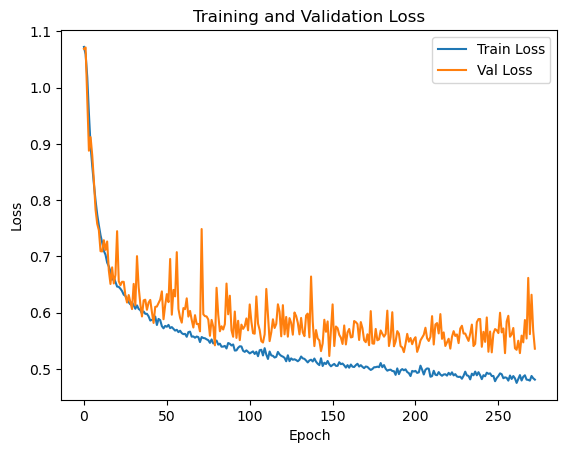

In [58]:
# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### Prediction and Submission Preparation

In [60]:
# Predicting on the test set
model.eval()
test_outputs = []
with torch.no_grad():
    for inputs in X_test:
        inputs = inputs.unsqueeze(0)  # Add batch dimension
        output = model(inputs)
        test_outputs.append(output.squeeze().cpu().numpy())

test_outputs = np.array(test_outputs)
test_predictions = np.argmax(test_outputs, axis=1)

# Print the first 5 and last 5 scores for verification
print("First 5 scores:", test_predictions[:5])
print("Last 5 scores:", test_predictions[-5:])

# Preparing submission file
submission = pd.DataFrame({"id": np.arange(len(test_predictions)), "Category": test_predictions})
submission.to_csv("submission.csv", index=False)


First 5 scores: [2 0 0 1 1]
Last 5 scores: [0 2 1 2 2]
